
## Step 0: Load The Data
*Add additional functions to this section vs. Step 1
*Add visualizations for additional details on old dataset (train.p/test.p) vs new dataset (train.p/test.p/valid.p)
*Add test if there are data duplicates in test.p and valid.p. Any dupliates will kill performance
(keep results out of grading notebook)
*Add np.historgram histogram norlalization experiments
*Preprocess the images to convert to grayscale, normalize to range +/-1, subtract out mean of entire train.p

In [1]:
# Load pickled data
import matplotlib.pyplot as plt
import pickle, cv2, csv, os, time
import numpy as np
from numpy import newaxis
from random import randint
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from matplotlib import gridspec
# Visualizations will be shown in the notebook.
%matplotlib inline

In [7]:
#careful we have RGB not BGR
#convention uppercase X means list or array, lowercase means single object like image

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def img_hist(img):
    clahe = cv2.createCLAHE()
    cle = clahe.apply(img)
    return cle 
    
#test wo scalar RGB adjustments; how much difference?
def rgb_to_gray(X_train):
    almost_gray = np.add(np.add(X_train[:,:,:,0],X_train[:,:,:,1]),X_train[:,:,:,2])
    return almost_gray/3.0

#x = 0.299r + 0.587g + 0.114b.
def rgb_gray(X_train):
    gray = np.add(np.add(X_train[:,:,:,0]*.299,X_train[:,:,:,1]*.587),X_train[:,:,:,2]*.114)
    return gray

#gives range [-1,1] vs. [0,1]. [0,1] better b/c no multiply by 0. Test
def normalize(X_train):
    return np.divide(np.subtract(X_train,128.),128.)

#[0,1]
def normalize_pos(X_train):
    return np.divide(X_train,255.)

def apply_hist(X):
    for idx,img in enumerate(X):
        equ = equalize_img(img)
        X[idx] = equ
    return X

def np_grayscale(img):
    return np.array(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))


def histo(im, nbin=10 ,xmin=0, xmax=255 ,normalized=True):
    ndim = im.ndim
    print (ndim)
    bins = np.linspace(xmin, xmax, nbin+1)
    hsv = matplotlib.colors.rgb_to_hsv(im/xmax) * xmax
    imhist, bin_edges = np.histogram(hsv[:,:,0], bins=bins, density=normalized)
    imhist = imhist * np.diff(bin_edges)
    return imhist


def rgb2gray(rgb_img):
    """
    Convert RGB image to grayscale
    Parameters:
      rgb_img : RGB image

    Returns:
      grayscale image

  """
    return np.dot(rgb_img[...,:3], [0.299, 0.587, 0.144])


#input grayscale
#output grayscale 
def equalize_img(img):
    return cv2.equalizeHist(img.astype(np.uint8))

#input: RGB image, integer for grayscale conversion
#output: greyscale image
#note to myself. Reformatting from (32,32) to (32,32,1) wont plot
#(32,32) will plot but wont fit into the NN. The NN wants (32,32,1) but this wont plot. 
#X_train_fixdims = X_train_normalized[...,newaxis] used for converting from (32,32)->(32,32,1)
def preprocess(X,version):
    if version==0:
        X_train_gray = rgb_gray(X)
    elif version==1:
        X_train_gray = rbg_to_gray(X)
    elif version == 2:
        X_train_gray = np_grayscale(X)
    elif version==3:
        X_train_gray = greyscale(X)
    else:
        print('error preprocess invalid grayscale version')
    X_histo = apply_hist(X_train_gray)
    X_train_normalized = normalize_pos(X_histo)
    # I never saw a difference w/ float64!!
    X_train_normalized = X_train_normalized.astype(np.float32)-np.mean(X_train_normalized).astype(np.float32)
    return X_train_normalized


def load_data():
    training_file = 'train.p'
    testing_file = 'test.p'
    valid_file = 'valid.p'
   
    with open(training_file, mode='rb') as f:
        train = pickle.load(f)
    with open(testing_file, mode='rb') as f:
        test = pickle.load(f)
    with open(valid_file, mode='rb') as f:
        valid = pickle.load(f)
   

        
    X_train, y_train, X_test, y_test = train['features'], train['labels'],test['features'], test['labels']
    X_valid, y_valid = test['features'], test['labels']
    
    return X_train, y_train, X_test, y_test, X_valid, y_valid



def clearAddedData():
    global rot
    global orig
    global labels
    rot = []
    orig = []
    labels = []
    

def load_csv():
    csv_dict = {}

    with open(os.getcwd()+'/signnames.csv', 'rt') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            if (row[0]!='ClassId'):
                csv_dict[int(row[0])] = row[1]

    return csv_dict

# process data to grayscale 0 mean over range +/- 1 
# you can plot X_train_pp but you cannot plot X_train_pp_format
# we need both versions for debugging. 
def preprocess_data():
    X_train_pp = preprocess(X_train,version=0)
    X_test_pp = preprocess(X_test,version=0)
    X_valid_pp = preprocess(X_valid,version=0)
       
# matplotlib cant plot these
# Note: can also do X_train_pp_format = X_train_pp[...,None] to add the extra axis
    X_train_pp_format = X_train_pp[...,newaxis]
    X_test_pp_format = X_test_pp[...,newaxis]
    X_valid_pp_format = X_valid_pp[...,newaxis]
    return X_train_pp, X_test_pp, X_valid_pp, X_train_pp_format, X_test_pp_format, X_valid_pp_format


In [8]:
# load csv_dict for plots
csv_dict = load_csv()
print (csv_dict)

clearAddedData()

{0: 'Speed limit (20km/h)', 1: 'Speed limit (30km/h)', 2: 'Speed limit (50km/h)', 3: 'Speed limit (60km/h)', 4: 'Speed limit (70km/h)', 5: 'Speed limit (80km/h)', 6: 'End of speed limit (80km/h)', 7: 'Speed limit (100km/h)', 8: 'Speed limit (120km/h)', 9: 'No passing', 10: 'No passing for vehicles over 3.5 metric tons', 11: 'Right-of-way at the next intersection', 12: 'Priority road', 13: 'Yield', 14: 'Stop', 15: 'No vehicles', 16: 'Vehicles over 3.5 metric tons prohibited', 17: 'No entry', 18: 'General caution', 19: 'Dangerous curve to the left', 20: 'Dangerous curve to the right', 21: 'Double curve', 22: 'Bumpy road', 23: 'Slippery road', 24: 'Road narrows on the right', 25: 'Road work', 26: 'Traffic signals', 27: 'Pedestrians', 28: 'Children crossing', 29: 'Bicycles crossing', 30: 'Beware of ice/snow', 31: 'Wild animals crossing', 32: 'End of all speed and passing limits', 33: 'Turn right ahead', 34: 'Turn left ahead', 35: 'Ahead only', 36: 'Go straight or right', 37: 'Go straight o

X_train shape: ((39209, 32, 32, 3), 'y_train (labels for X_train) shape:', (39209,))
X_test shape: (12630, 32, 32, 3) y_test (labels for X_test) shape: (12630,)
X_valid shape: (12630, 32, 32, 3) y_valid (labels for X_train) shape: (12630,)


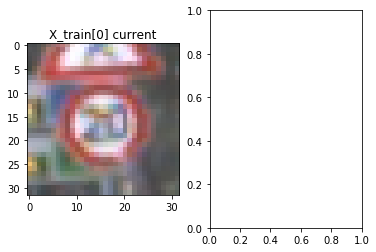

In [11]:
# TODO: Fill this in based on where you saved the training and testing dat
# the .p files are preprocessed from the download site above

X_train, y_train, X_test, y_test, X_valid, y_valid = load_data()


print ('X_train shape:',(X_train.shape , 'y_train (labels for X_train) shape:', y_train.shape))
print ('X_test shape:',(X_test.shape), 'y_test (labels for X_test) shape:',(y_test.shape))
print ('X_valid shape:',(X_valid.shape), 'y_valid (labels for X_train) shape:', y_valid.shape)


#plot the original image. The dataset changed as I was doing the assignment. 
#The original X_train[0] was a 20kmh speed sign in color now we have a grayish End of no passing sign
# they look blurred compared to the original. This is I assume an artifact of creating images for the assignment
# they also look shuffled.

gs1 = gridspec.GridSpec(1, 2)
gs1.update(wspace=2.0, hspace= 2.0)
plt.subplot(1,2,1)
plt.imshow(X_train[0])
plt.title('X_train[0] current')
plt.subplot(1,2,2)


In [7]:
# does the new train.p dataset contain color? Did they preprocess the color out? No longer matches the download 
# from the website where the first image is clearly the one on the right. 
# this shows old training set and new set{train.p, valid.p, test.p are different}

for idx,img in enumerate(X_train):
    if( np.array_equal(X_train[idx],O_train[0])):
        print('found')

for idx,img in enumerate(X_valid):
    if( np.array_equal(X_valid[idx],O_train[0])):
        print('found')

# not good...this means I need to create my own dataset from the download bc I have no idea what the train.p is. 
#try reverse search,

for idx,img in enumerate(O_train):
    if( np.array_equal(O_train[idx],X_train[0])):
        print('found')

for idx,img in enumerate(X_valid):
    if( np.array_equal(X_valid[idx],X_train[0])):
        print('found')

#error check, make sure images in the test set and validation set are not duplicates


3
3


(array([ 4.,  2.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  2.]),
 array([ 0.04003906,  0.059375  ,  0.07871094,  0.09804688,  0.11738281,
         0.13671875,  0.15605469,  0.17539062,  0.19472656,  0.2140625 ,
         0.23339844]),
 <a list of 10 Patch objects>)

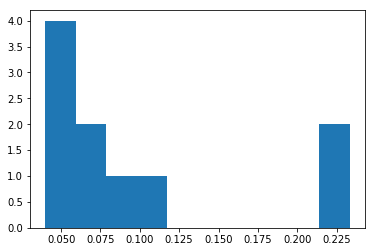

In [6]:
# test normalization of histograms in hsv space and or using canned routines. 

#looks like they preprocessed the images. Moved to grayscale already
#the original didnt have this
im=O_train[0]
plt.hist(histo(O_train[0]))


3
3


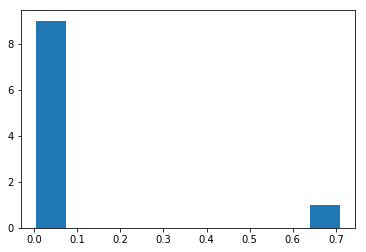

In [7]:
plt.hist(histo(X_train[0]))
print(X_train[0].ndim)

(32, 32) <class 'numpy.ndarray'>
(32, 32)
<class 'numpy.ndarray'>
equ.shape: (32, 32)


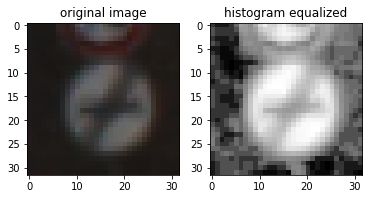

In [8]:
#plot the 2 images before and after histogram equalization
#plt.imhist(histo(img_20km))
#plt.imhist(histo(img_no))

h,w,depth = X_train[0].shape
vis2=np.zeros((h,w),np.float32)
print (vis2.shape,type(vis2))


G_Train = rgb_gray(X_train)
print (G_Train[0].shape)
print (type(G_Train[0][0]))
equ = cv2.equalizeHist(G_Train[0].astype(np.uint8))
#it does LOOK lighter!! or brighter. but the edges look worse? 
print ('equ.shape:',equ.shape)


#plt.imshow(equ,cmap='gray')
gs1 = gridspec.GridSpec(1, 2)
#this spacing doesnt make a difference
gs1.update(wspace=2.0, hspace= 2.0)
plt.subplot(1,2,1)
plt.imshow(X_train[0],cmap='gray')
plt.title('original image')
plt.subplot(1,2,2)
plt.imshow(equ,cmap='gray')
plt.title('histogram equalized')

0 255
moved mean from: 43.8818359375  to: 132.809570312


([array([ 1.,  0.,  0.,  1.,  7.,  0.,  1.,  0.,  0.,  0.]),
  array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  2.])],
 array([   0. ,   25.5,   51. ,   76.5,  102. ,  127.5,  153. ,  178.5,
         204. ,  229.5,  255. ]),
 <a list of 2 Lists of Patches objects>)

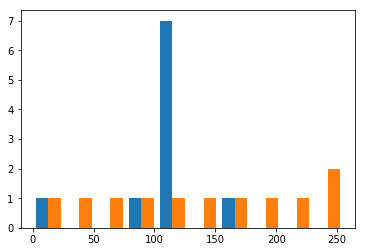

In [9]:
# the peak is in the middle with density=False, is on LHS near y axis with density=True

print (np.amin(equ),np.amax(equ))
print ('moved mean from:',np.mean(X_train[0]),' to:',np.mean(equ))
plt.hist(np.histogram(equ, bins=10 ,density=False))

#note density=False and density=True give 2 different plots. 

X_train_pp shape: (34799, 32, 32)
X_test_pp shape: (12630, 32, 32)
X_valid_pp shape: (12630, 32, 32)
X_train_pp_format shape: (34799, 32, 32, 1)
X_test_pp_format shape: (12630, 32, 32, 1)
X_valid_pp_format shape: (12630, 32, 32, 1)


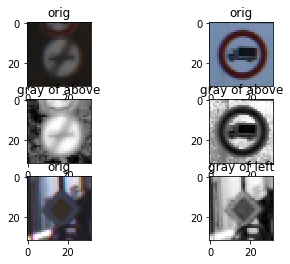

In [24]:
# process loaded data

X_train_pp, X_test_pp, X_valid_pp, X_train_pp_format, X_test_pp_format, X_valid_pp_format = preprocess_data()


print('X_train_pp shape:', X_train_pp.shape)
print('X_test_pp shape:', X_test_pp.shape)
print('X_valid_pp shape:', X_valid_pp.shape)

print('X_train_pp_format shape:', X_train_pp_format.shape)
print('X_test_pp_format shape:', X_test_pp_format.shape)
print('X_valid_pp_format shape:', X_valid_pp_format.shape)


#TBD: find the original image and see if we can clean these up using the bounding box

gs1 = gridspec.GridSpec(3, 2)
gs1.update(wspace=2.0, hspace= 2.0)
plt.subplot(3,2,1)
plt.imshow(X_train[0])
plt.title('orig')
#plt.title(csv_dict[y_train[0]])
#test 
plt.subplot(3,2,2)
plt.imshow(X_test[0])
plt.title('orig')
#plt.title(csv_dict[y_test[0]])

plt.subplot(3,2,3)
plt.imshow(X_train_pp[0],cmap='gray')
plt.title('gray of above')
#plt.title(csv_dict[y_train[0]])

plt.subplot(3,2,4)
plt.imshow(X_test_pp[0],cmap='gray')
plt.title('gray of above')
#plt.title(csv_dict[y_test[0]])

       
plt.subplot(3,2,5)
plt.imshow(X_valid[10],cmap='gray')
plt.title('orig')
#plt.title(csv_dict[y_valid[10]])
       
plt.subplot(3,2,6)
plt.imshow(X_valid_pp[10],cmap='gray')
plt.title('gray of left')
#plt.title(csv_dict[y_valid[10]])

#### Image Normalization
We can see after conversion to grey sacle the edges are enhanced by removing the dark overcast shadows in
both examples. 1) in the cells below the histogram and the last row of the cell above. The edges in the no passing
sign and the diagonal sign show up more clear; at least to the human eye. 
An interesting experiment would be to create a separate sobel image set as a set of features similar to what Karpathy 
did. One open question is if the histgram equalization for default=False vs default=True makes a difference. One difference 
would be in creating different mean values after histogram equalization. We adjust the mean back to 0 after histogram equaliaztion. 

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [27]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: Number of testing examples.
n_valid = X_valid.shape[0]


# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(csv_dict)

print("Number of training examples =", n_train, 'number of training labels:', y_train.shape[0])
print("Number of testing examples =", n_test, 'number of testing labels:', y_test.shape[0])
print("Number of validation examples =", n_valid, 'number of valid labels:', y_valid.shape[0])

print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

#verify float32
print('---------------------------')
print ('verify range of data -/+ 1')
print(X_train_pp_format.dtype)
print ('min,max,mean X_train: ',np.amin(X_train_pp_format),np.amax(X_train_pp_format), np.mean(X_train_pp_format))
print(X_test_pp_format.dtype)
print ('min,max,mean X_test: ',np.amin(X_test_pp_format),np.amax(X_test_pp_format), np.mean(X_test_pp_format))
print(X_valid_pp_format.dtype)
print ('min, max, mean X_valid: ', np.amin(X_valid_pp_format),np.amax(X_valid_pp_format), np.mean(X_valid_pp_format))



Number of training examples = 34799 number of training labels: 34799
Number of testing examples = 12630 number of testing labels: 12630
Number of validation examples = 12630 number of valid labels: 12630
Image data shape = (32, 32, 3)
Number of classes = 43
---------------------------
verify range of data -/+ 1
float32
min,max,mean X_train:  -1.02517 0.967015 6.24237e-08
float32
min,max,mean X_test:  -1.02813 0.964058 -2.25128e-08
float32
min, max, mean X_valid:  -1.02813 0.964058 -2.25128e-08


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

There is a German traffic sign dataset here: 
http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset#Downloads

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

(array([  30.,  240.,  240.,  150.,  210.,  210.,   60.,  150.,  150.,
         150.,  210.,  150.,  210.,  240.,   90.,   90.,   60.,  120.,
         120.,   30.,   60.,   60.,   60.,   60.,   30.,  150.,   60.,
          30.,   60.,   30.,   60.,   90.,   30.,   90.,   60.,  120.,
          60.,   30.,  210.,   30.,   60.,   30.,   30.]),
 array([  0.        ,   0.97674419,   1.95348837,   2.93023256,
          3.90697674,   4.88372093,   5.86046512,   6.8372093 ,
          7.81395349,   8.79069767,   9.76744186,  10.74418605,
         11.72093023,  12.69767442,  13.6744186 ,  14.65116279,
         15.62790698,  16.60465116,  17.58139535,  18.55813953,
         19.53488372,  20.51162791,  21.48837209,  22.46511628,
         23.44186047,  24.41860465,  25.39534884,  26.37209302,
         27.34883721,  28.3255814 ,  29.30232558,  30.27906977,
         31.25581395,  32.23255814,  33.20930233,  34.18604651,
         35.1627907 ,  36.13953488,  37.11627907,  38.09302326,
         39.06976

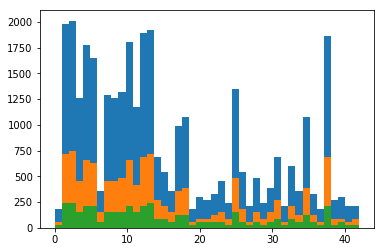

In [37]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.


#plot histogram of classes/images for training. 
plt.hist(train['labels'], bins = n_classes)
plt.hist(test['labels'], bins= n_classes)
plt.hist(valid['labels'],bins= n_classes)
#this is awful. Poor distribution. 

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:** 
    1. color -> grayscale, 
    2. subtract mean of image set, this is the mean of train.p not the mean of train.p+valid.p+test.p. 
    This is not the mean per image. 
    3. normalization to (+/-)1, 
    4. rotation +-15 degrees, from paper
    5. translation [-2,2] from paper

    Histgram normalization from lecture in HSV space. 
    Measure effect on validation/test accuracy.  
    The new dataset (the one with the valid.p) was converted to semi-grayscale. 
    This eliminates the rotation artifacts
    which are dark black areas. Those can be interpreted as lines by the classifier.
    


In [ ]:
### Generate additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

#additional data for classes which are low in training examples, rotate +-15 degrees, translate, histogram for darkness
#POINT: ndimage is awful. Use opencv
#POINT: we want a rotation wo the black edges after rotation which enlarges and shifts image
#images below show proof of artifacts and correction using warpTransform to unshift and shrink
#
from scipy import ndimage

def plotRot():
    img = O_train[0]
    

    rot = ndimage.rotate(img,15,reshape=True)

    print ("img.shape:",img.shape,"rotate shape:",rot.shape)
    blur=ndimage.gaussian_filter(rot,.5)
    print ('blur shape:', blur.shape)
    #CAREFUL THE CROP MOVES THE IMAGE and makes it bigger!!!
    #CAREFUL CROP uses gaussian blur output as starting point

    cols,rows=32,32
    rotAngle=15
    scaleFactor=.9 #expanded after crop
    M_plus = cv2.getRotationMatrix2D((cols/2,rows/2),rotAngle,scaleFactor)
    M_minus = cv2.getRotationMatrix2D((cols/2,rows/2),-rotAngle,scaleFactor)
    #32,32 is final destination size

    dst_plus = cv2.warpAffine(img,M_plus,(cols,rows))
    dst_minus = cv2.warpAffine(img,M_minus,(cols,rows))

    crop_plus = dst_plus[4:30,4:30]
    crop_minus = dst_minus[4:30,4:30]

    #we dont need this b/c the warpaffine gives a final size
    #dst_resize = cv2.resize(dst,(32,32))
    print('dst_plus shape:', dst_plus.shape)
    print('dst_minus shape:', dst_minus.shape)
    print('crop_plus shape:', crop_plus.shape)
    print('crop_minus shape:', crop_minus.shape)

    crop_plus_resize = cv2.resize(crop_plus,(32,32))
    crop_minus_resize = cv2.resize(crop_minus,(32,32))

    print ('crop_plus_resize shape:', crop_plus_resize.shape)
    print ('crop_plus_resize shape:', crop_minus_resize.shape)


    #there are a couple ways to draw figures in grids. I can never seem to remember them all and websearches are confusing
    #the easiest is 3 lines
    # fig = plt.figure
    # fig.add_subplot(1,7,1) which is 1 row with 7 columns adding first subplot for the last argument
    # plt.imshow(img)
    # easy to remember but painful to add more rows or columns cause you have to change all the constants
    # the second way is to use a plt.tight_layout
    #
    #
    # the third way is to use a gridspec

    gs1 = gridspec.GridSpec(5, 5)
    gs1.update(wspace=1.0, hspace=0.5) 
    plt.figure(figsize=(12,12))
    
    ax1 = plt.subplot(gs1[0])
    plt.subplot(5,5,1)
    plt.imshow(img)
    plt.title('orig')
    
    ax1 = plt.subplot(gs1[1])
    plt.subplot(5,5,2)
    plt.imshow(rot)
    plt.title('rot(ndimg)')
    
    ax1 = plt.subplot(gs1[2])
    plt.subplot(5,5,3)
    plt.imshow(blur)
    plt.title('blur')
    
    ax1 = plt.subplot(gs1[3])
    plt.subplot(5,5,4)
    plt.imshow(dst_plus)
    plt.title('dst_plus')
    
    ax1 = plt.subplot(gs1[4])
    plt.subplot(5,5,5)
    plt.imshow(dst_minus)
    plt.title('dst_min')
    
    ax1 = plt.subplot(gs1[5])
    plt.subplot(5,5,6)
    plt.imshow(crop_plus)
    plt.title('crop pls')
    
    ax1 = plt.subplot(gs1[6])
    plt.subplot(5,5,7)
    plt.imshow(crop_minus)
    plt.title('crop minus')
    
    ax1 = plt.subplot(gs1[7])
    plt.subplot(5,5,8)
    plt.imshow(crop_minus_resize)
    plt.title('cm resize')
    
    ax1 = plt.subplot(gs1[8])
    plt.subplot(5,5,9)
    plt.imshow(crop_plus_resize)
    plt.title('plus resize')

plotRot()    

#note: the crop_plus and crop_minus still look bigger than the original 
#this data is different; the black edge effects disappear w grayscale!!!

num rot, num labels 34799 34799
numAdded: 34799


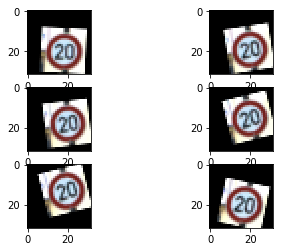

In [6]:
# use opencv. 
#better to convert these to grayscale before rotation
#scalefactor 3 gives .7 to 1.0 range. These are all smaller. Would bigger ones help? 
def rotImageCV(image, rotAngle, transFactor, scaleFactor):
   
    rows,cols,ch = image.shape
    #gray_image = rgb_gray(image)
    #M_plus = cv2.getRotationMatrix2D((cols/2,rows/2),randint(0,rotAngle),scaleFactor)
    M = cv2.getRotationMatrix2D((cols/2,rows/2),randint(-rotAngle,rotAngle),randint(10-scaleFactor,10)*.1)
    rotated_img = cv2.warpAffine(image,M,(cols,rows))
    shiftX = randint(-transFactor,transFactor)
    shiftY = randint(-transFactor,transFactor)
    M_translate = np.float32([[1,0,shiftX],[0,1,shiftY]])
    rot_trans_img = cv2.warpAffine(rotated_img,M_translate,(cols,rows))
    
    return rot_trans_img
    
    
def addData():
    numAdded = 0
    for i in range(0,43):
        for idx, img in enumerate (X_train):
            if (y_train[idx]==i):
                #if(idx%10==0):
                #for x in range(10):
                r = rotImageCV(img,15,5,3)
                orig.append(img)
                rot.append(r)
                labels.append(0)
                numAdded +=1
        
    print ('num rot, num labels',len(rot), len(labels))
    print ('numAdded:', numAdded)
    return orig, added

#plot some examples
gs1 = gridspec.GridSpec(3, 2)
#this spacing doesnt make a difference
gs1.update(wspace=2.0, hspace= 2.0)
plt.subplot(3,2,1)
plt.imshow(rot[10])

plt.subplot(3,2,2)
plt.imshow(rot[11])

plt.subplot(3,2,3)
plt.imshow(rot[12])

plt.subplot(3,2,4)
plt.imshow(rot[13])

plt.subplot(3,2,5)
plt.imshow(rot[14])


plt.subplot(3,2,6)
plt.imshow(rot[15])


(34799, 32, 32, 3)
we dont care about rot_np, rot_np min, max, mean 0 255 54.8076630985
(34799, 32, 32)
rot_pp min, max, mean -0.350769 0.649231 6.88802e-09
(34799, 32, 32, 1)
rot_pp_format min, max, mean -0.350769 0.649231 6.88802e-09
before adding images X_train_pp shape (34799, 32, 32) rot_pp shape: (34799, 32, 32)
before adding images y_train shape: (34799,)  labels.shape (34799,)
X_train_rot_pp shape (69598, 32, 32)
y_train_labels shape: (69598,)


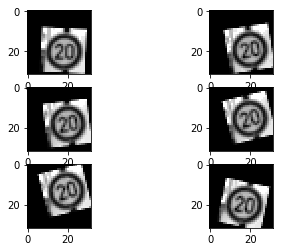

In [7]:
#add rot[] to X_train, labels to y_train[]
#1) rot is a list convert to np array
#2) preprocess the rot to _pp then to pp_format
#3) verify min/max = +- 1 for preprocess. 
#Input: rot[], labels[]
#output X_train_rot_pp_format y_test_labels; make sure to set X_train and y_train to the output
rot_np=np.array(rot)
labels = np.array(labels)

print (rot_np.shape)
print('we dont care about rot_np, rot_np min, max, mean',np.amin(rot_np),np.amax(rot_np),np.mean(rot_np))
rot_pp = preprocess(rot_np,0)

print (rot_pp.shape)
print('rot_pp min, max, mean',np.amin(rot_pp),np.amax(rot_pp),np.mean(rot_pp))

rot_pp_format=rot_pp[...,newaxis]
print(rot_pp_format.shape)
print('rot_pp_format min, max, mean',np.amin(rot_pp_format),np.amax(rot_pp_format),np.mean(rot_pp_format))

#this is not formatted. Make sure you are consistent and appending labels AND new images at end. 
#this error is hard to debug cause you just get a crappy accuracy rate. 

print('before adding images X_train_pp shape',X_train_pp.shape, 'rot_pp shape:', rot_pp.shape)
print('before adding images y_train shape:', y_train.shape,' labels.shape', labels.shape)
X_train_rot_pp = np.concatenate((X_train_pp,rot_pp))
y_train_labels = np.concatenate((y_train,labels))


#fucked up the order!!! 
X_train_rot_pp_format=np.concatenate((X_train_pp_format,rot_pp_format))
print('X_train_rot_pp shape',X_train_rot_pp.shape)
print ('y_train_labels shape:', y_train_labels.shape)

gs1 = gridspec.GridSpec(3, 2)
#this spacing doesnt make a difference
gs1.update(wspace=2.0, hspace= 2.0)
plt.subplot(3,2,1)
plt.imshow(rot_pp[10],cmap='gray')

plt.subplot(3,2,2)
plt.imshow(rot_pp[11],cmap='gray')

plt.subplot(3,2,3)
plt.imshow(rot_pp[12],cmap='gray')

plt.subplot(3,2,4)
plt.imshow(rot_pp[13],cmap='gray')

plt.subplot(3,2,5)
plt.imshow(rot_pp[14],cmap='gray')


plt.subplot(3,2,6)
plt.imshow(rot_pp[15],cmap='gray')

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**
    The dataset was changed from a train.p test.p to include a valid.p. This makes it easier to compare results. This changed the 
    code. Did not need the validation split using: 
    #shuffle before creating validation set. 
    X_train, y_train = shuffle(X_train, train['labels'])
    print ("after shuffle X_train shape", X_train.shape, "y_train shape:", y_train.shape)

    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, stratify = y_train, test_size=.25, random_state=123)
   
    Test Rotations: rotated +-15 degrees from the paper. The rotations using ndimage created black edges; used opencv to ger 
    of these artifacts. A rotataion translates and magnifies the image because we crop the image to remove the black edges. 
    
    The paper scales images from .9 to 1.1 and adds [-2,2] offset to the images. 
    
    View the test images to see what types of transformations are needed. Definitely brightness changes are required.
    
### Generated Data Summary:
1. Generated data following the recommendations from paper. This increased validation accuracy from 93.5 to 95.2%. 
Listed the validation accuracy results for added images in test.ipynb to keep the workbook length manageable. The 
browser runs out of memory on a 16GB macbook. Did not include test accuracy.. forgot.. ran on TitanX. 
2. Without data generation still get >93%. 
3. To add data, run the 2 notebook cells. The first one generates data and the second one formats the generated
data and adds it to X_train. Data generated in addData(). Have options to generate one new jittered image per 10 
images or multiple jittered images per train.p image. Uncomment lines to add data. Verify the number generated
is correct by looking at the X_train count. addData() adds an image to X_train and a label to y_train. 
    

In [25]:
print (len(rot))
if len(rot)==0:
    X_train = X_train_pp_format
else:
    X_train=X_train_rot_pp_format  
    y_train = y_train_labels

#these should not be affected by adding data
X_test = X_test_pp_format
X_valid = X_valid_pp_format

print ('X_train shape:', X_train.shape, 'y_train shape:', y_train.shape)
print ('X_valid shape:',X_valid.shape, 'y_valid shape:', y_valid.shape)
print ('X_test shape:',X_test.shape, 'y_test shape', y_test.shape)

0
X_train shape: (34799, 32, 32, 1) y_train shape: (34799,)
X_valid shape: (12630, 32, 32, 1) y_valid shape: (12630,)
X_test shape: (12630, 32, 32, 1) y_test shape (12630,)


In [26]:
### Define your architecture here.
### Feel free to use as many code cells as needed.


#EPOCHS = 200
# adding more data requires more epochs
#EPOCHS= 30  #Test Accuracy = 0.972
EPOCHS = 10 #Test Accuracy = 0.922
BATCH_SIZE = 100
patch_size = 5
num_color = 1 
depth = 6

save_path = os.getcwd()+'/10EPOCHS.ckpt'
#save_path = os.getcwd() + '/30EPOCHS.ckpt'
#save_path = os.getcwd() + '/100EPOCHS.ckpt'

from tensorflow.contrib.layers import flatten


def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(patch_size, patch_size, num_color, depth), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(depth))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    
    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)
    
    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    #tf.nn.dropout(conv1, .9)

    
    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)
    #tf.nn.dropout(conv2, .7)

    
    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    flat = tf.contrib.layers.flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 200), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(200))
    fc1   = tf.matmul(flat, fc1_W) + fc1_b
    
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)
    h_fc1_drop = tf.nn.dropout(fc1, keep_prob)
    
    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(200, 100), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(100))
    fc2    = tf.matmul(h_fc1_drop, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)
    #print ("after relu fc2 shape:", fc2.get_shape())
    
    h_fc2_drop = tf.nn.dropout(fc2, keep_prob)
    
    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(100, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(h_fc2_drop, fc3_W) + fc3_b
    
    print ('logits shape:',logits.get_shape())
    return logits


In [27]:
#set variables x is X_train or input training images, y is y_train or labels

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
#dropout from tf mnist webpage https://www.tensorflow.org/get_started/mnist/pros
keep_prob = tf.placeholder(tf.float32)

In [28]:
rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y))
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

logits shape: (?, 43)


In [29]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()


def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    total_loss = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        loss, accuracy = sess.run([loss_operation,accuracy_operation], feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
        total_loss += (loss * len(batch_x))
    return total_loss/num_examples , total_accuracy / num_examples

In [30]:
from sklearn.utils import shuffle

#print ('X_train_pp_format shape:', X_train_pp_format.shape)
    #X_train = X_train_pp_format

print ('X_train shape', X_train.shape, 'y_train shape', y_train.shape)
print ('X_test shape', X_test.shape, 'y_test shape:', y_test.shape)
print('X_valid shape:', X_valid.shape, 'y_valid shape:', y_valid.shape)
print ('logits shape:', logits.get_shape())
   
# we should shuffle data in runModel
init_op = tf.global_variables_initializer()
#diff tf.initialize_all_variables()
print ("init_op set globally")        

def runModel(X_train,y_train,X_valid,y_valid, init_graph):
    '''
    '''
    startTime = time.time()
    X_train, y_train = shuffle(X_train, y_train)
    
    valid_loss = []
    valid_acc = []
    
    with tf.Session() as sess:
        sess.run(init_op)
        num_examples = len(X_train)
        print ('num_examples', num_examples)
        print("Training...")
        
        for i in range(EPOCHS):
            X_train, y_train = shuffle(X_train, y_train)
            for offset in range(0, num_examples, BATCH_SIZE):
                end = offset + BATCH_SIZE
                #print ('offset:', offset, 'end:',end)
                batch_x, batch_y = X_train[offset:end], y_train[offset:end]
                #print ('batch_x shape:',batch_x.shape,' batch_y.shape', batch_y.shape)
                loss = sess.run(training_operation, feed_dict={x: batch_x, y: batch_y,keep_prob: 0.5})
                # add batch normalization
                
                
                
            #batch_loss, batch_accuracy = evaluate(batch_x,batch_y)
            #print("batch Accuracy = {:.3f}".format(batch_accuracy))
            validation_loss, validation_accuracy = evaluate(X_valid, y_valid)
            valid_acc.append(validation_accuracy)
            valid_loss.append(validation_loss)
           
            print("EPOCH {} ...".format(i+1))
            print("Validation Accuracy = {:.3f}".format(validation_accuracy))
            #valid_acc.append(validation_accuracy)
            #print_epoch_stats(i,sess,batch_x, batch_y)
            print()
        
        saver.save(sess, save_path)
        print("Model saved")
        endTime = time.time()
        print('elapsed time mins:', (endTime-startTime)/60.)
        return valid_loss, valid_acc

    
valid_loss,valid_acc = runModel(X_train,y_train,X_valid,y_valid, init_op)


X_train shape (34799, 32, 32, 1) y_train shape (34799,)
X_test shape (12630, 32, 32, 1) y_test shape: (12630,)
X_valid shape: (12630, 32, 32, 1) y_valid shape: (12630,)
logits shape: (?, 43)
init_op set globally
num_examples 34799
Training...
EPOCH 1 ...
Validation Accuracy = 0.733

EPOCH 2 ...
Validation Accuracy = 0.843

EPOCH 3 ...
Validation Accuracy = 0.885

EPOCH 4 ...
Validation Accuracy = 0.895

EPOCH 5 ...
Validation Accuracy = 0.913

EPOCH 6 ...
Validation Accuracy = 0.917

EPOCH 7 ...
Validation Accuracy = 0.926

EPOCH 8 ...
Validation Accuracy = 0.927

EPOCH 9 ...
Validation Accuracy = 0.930

EPOCH 10 ...
Validation Accuracy = 0.928

Model saved
elapsed time mins: 2.297852432727814


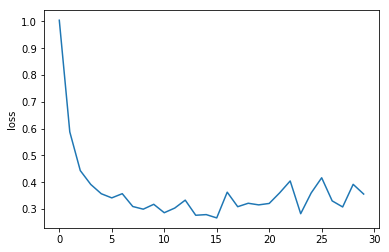

In [20]:
# 30 epochs 3480 added data 
plt.plot(valid_loss)
plt.ylabel('loss')
plt.show()

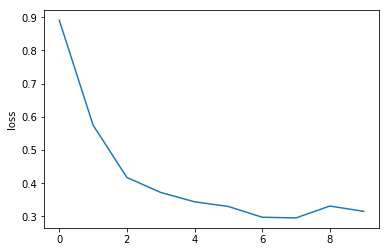

In [14]:
# addition of 3480 data, every 10th sample generate one rotated/trans image
# 10 epochs; this model should be stopped after 7 epochs. This graph looks like what is in the 
# slides. 
plt.plot(valid_loss)
plt.ylabel('loss')
plt.show()

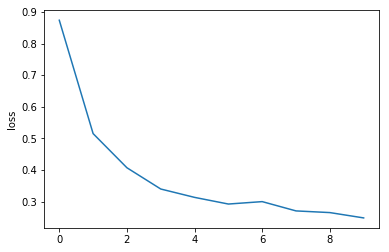

In [42]:
# no addition of data, 10 epochs
plt.plot(valid_loss)
plt.ylabel('loss')
plt.show()

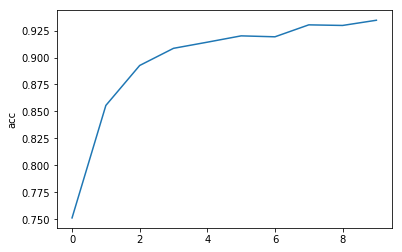

In [43]:
plt.plot(valid_acc)
plt.ylabel('acc')
plt.show()

In [ ]:
# run an ensemble of models say 10 and calculate the mean/std deviation from these
# run this in the titanX
ten_acc = []
ten_loss = []
for idx in xrange(10):
    #should work wo mods since we only return validation_accuracy
    titanX_loss, titanX_acc = runModel(X_train,y_train,X_valid,y_valid)
    ten_acc.append(titanX_acc)
    ten_loss.append(titanX_loss)

with open('loss.txt', 'w') as lossfile:
    pickle.dump(ten_loss,lossfile)
with open('acc.txt', 'w') as accfile:
    pickle.dump(acc_loss, accfile)
    



### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**
    1) copied lenet architecture for MNIST, added dropout using paper. 
    Layers+ Sizes: 
        1) ConvLayer1: 32x32x1
        2) ConvLayer2: 14x14x6
        3) FC1: 400
        4) FC2: 120
        5) FC3: 84
       

In [45]:
#difference between latest checkpoint and save? 
with tf.Session() as sess:
    saver.restore(sess, save_path)

    test_loss, test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.935


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:** Adam Optimizer. 
    number of training examples = batch_size*#epochs
    hyperparamters: 
    
    Experiment: Disclaimer(This has nothing to do with our data): 
    30 samples in validation set is Satistically Significant. Lecture 26 Intro to TF
    if 3000 examples in validation set, 1%*3000/100=30 examples. So 1% accuarte. 
    7842*x%/100=30 examples; x=3000/7842=.38. Accurate to ~99%-.4=98.6. Is this a correct statement?
    
    
    https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf
    Adam Optimizer
    Batch Size: 100
    Epochs: 10 for experiment run on MacBook when I need result
    Epochs: 100 run in TitanX plot Validation Accuracy as it improves then increases. Use this as an approximation
    to the rising loss curve. 
    
    If I did nothing to the images and used the LeNet architecture from lecture then I got 93% accuracy. This was enough
    to meet the project goals. However I was interested in meeting the 99% accuracy as mentioned in the paper. It was 
    faster to reimplemment the LeNet architecture in Keras and modify it to get 98% accuracy. 
    
    The CV modifications were not necessary aside from normalization for the keras implementation. Adding mean normalization
    and jittering made a small difference on the non Keras implemenation from 93.5% to 95%. This was not enough to get to 
    99%. 
    
    Iterate using the test dataset and where the errors are by class. I printed out the test error in a separate workbook test.ipynb
    This cell was cut and paste from this workbook to make grading easier. The notebook is too long otherwise. 
    
    
    
    

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**
    Started with LeNet architecture. Trial and error to get something working
    Hyperparameter tuning: 
    Step 1) Implemented improvements from lecture including dropout. 
    Step 2) Use Epoch=10 for faster tuning. See effects of CV features like normalization; greyscale, dropout parameters. 
    For final answer run 100 or 1000 epochs and plot until you see the increase in loss indicating overfitting. Stop
    before this increase for the model to use. 
    

### Error Analysis
Document where the errors are occurring. In what class and see if adding more augmentation helps
Not part of assignment. The running and printing of the probabilities for test.p are not included. These
are in test.ipynb. Use the results to show which classes are inaccurate and add additonal data to reduce. 
Note: these are probabilities. Do not view result as consistent. One way to measure is to run 10 runs and see
which classes are more uncertain, if these are the classes with less samples which indicate underfitting. 


In [56]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

#testMe=[]
# you should be able to put the whole array here!!!
#X_test_pp_format or X_valid_pp_format into the feed_dict
#testMe.append(X_test_pp_format[0])
#T_test=np.array(testMe)
#print('T_test shape:',T_test.shape)

with tf.Session() as sess:
    saver.restore(sess, save_path )
    softmax = tf.nn.softmax(logits)
    top_k_val, top_k_idx = tf.nn.top_k(softmax, k=5)
    
    #top_k_vals, top_k_idxs = sess.run([top_k_val, top_k_idx], feed_dict={x: T_test, keep_prob : 1.0})
    top_k_vals, top_k_idxs = sess.run([top_k_val, top_k_idx], feed_dict={x: X_test_pp_format, keep_prob : 1.0})


---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

xx: .DS_Store fileext: 
xx: 20_km-h.jpg fileext: .jpg
processing xx: 20_km-h.jpg
image.shape  (2368, 3552, 3)
small.shape:  (32, 32, 3)


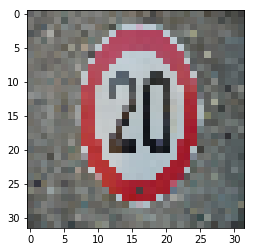

xx: 20km.jpeg fileext: .jpeg
processing xx: 20km.jpeg
image.shape  (225, 225, 3)
small.shape:  (32, 32, 3)


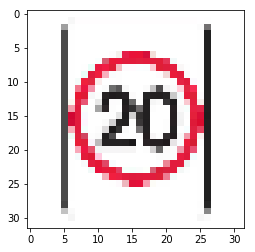

xx: 20km_white.png fileext: .png
xx: 20km_whiteblackline.png fileext: .png
xx: 20kmbrick.png fileext: .png
xx: 30-kph-sign.jpg fileext: .jpg
processing xx: 30-kph-sign.jpg
image.shape  (391, 655, 3)
small.shape:  (32, 32, 3)


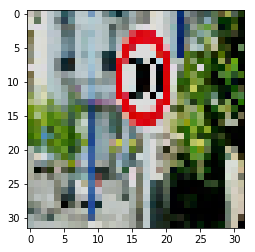

xx: 30km.png fileext: .png
xx: 50kmhr.jpg fileext: .jpg
processing xx: 50kmhr.jpg
image.shape  (681, 1024, 3)
small.shape:  (32, 32, 3)


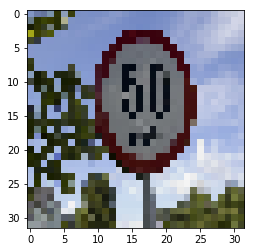

xx: one fileext: 
xx: Speed_limit_sign,_20_km-h.jpg fileext: .jpg
processing xx: Speed_limit_sign,_20_km-h.jpg
image.shape  (2368, 3552, 3)
small.shape:  (32, 32, 3)


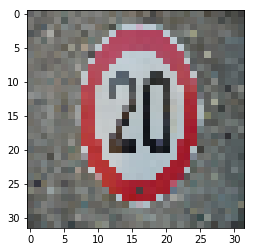

X_OUTSIDE_process shape (5, 32, 32)
X_OUTSIDE shape (5, 32, 32, 1)
float32
labels: [0, 0, 1, 2, 0]


In [31]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import matplotlib.image as mpimg
import os

imgs_path = os.getcwd()+'/images/'
labels=[]
imgs = os.listdir(imgs_path)
imgs_list = []

#does x fuck with the x placeholder in TF? Of course it does. Change to xx. 
#one would think a loop variable would have a separate scope. But no. 
for xx in imgs:
    print('xx:',xx, 'fileext:', os.path.splitext(xx)[1])
    if(xx !='.DS_Store' and (os.path.splitext(xx)[1]=='.jpg' or os.path.splitext(xx)[1]=='.jpeg')):
        print ('processing xx:',xx)
        image = mpimg.imread(imgs_path+xx)
        print ('image.shape ',image.shape)
        small=cv2.resize(image,(32,32))
        imgs_list.append(small)
        if('20' in xx):
            labels.append(0)
        elif('30' in xx):
            labels.append(1)
        elif('50' in xx):
            labels.append(2)
        else:
            print ('error')
        print ('small.shape: ',small.shape)
        plt.imshow(small)
        plt.show()
    
X_OUTSIDE_IMAGE = np.array(imgs_list)
X_OUTSIDE_pp = preprocess(X_OUTSIDE_IMAGE,version=0)
X_OUTSIDE_pp_format=X_OUTSIDE_pp[...,newaxis]
#X_OUTSIDE_pp_format=X_OUTSIDE_pp_format.astype(np.float32)
print ('X_OUTSIDE_process shape', X_OUTSIDE_pp.shape)
print ('X_OUTSIDE shape',X_OUTSIDE_pp_format.shape)
print (X_OUTSIDE_pp_format.dtype)
print ('labels:',labels)

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**
The downsampling from larger resolutions not only causes blurring but artifacts in distortion of the images. 
Some of the images have vertical lines, smoe have trees in the background. 

In [39]:
testMe=[]
testMe.extend(X_OUTSIDE_pp_format)
T_test=np.array(testMe)
labels=np.array(labels)
print('T_test shape:',T_test.shape)

#
with tf.Session() as sess:
    saver.restore(sess, save_path )
    softmax = tf.nn.softmax(logits)
    #classes = sess.run(tf.argmax(logits, 1), feed_dict={x: T_test, keep_prob : 1.0})
    top_k_val, top_k_idx = tf.nn.top_k(softmax, k=5)   
    top_k_vals, top_k_idxs = sess.run([top_k_val, top_k_idx], feed_dict={x: T_test, keep_prob : 1.0})



T_test shape: (5, 32, 32, 1)


In [40]:
for y in range(top_k_idxs.shape[0]):
    for x in range(len(top_k_idxs[0])):
        #print ('x:',x, 'y:',y)
        if(x==0 and (labels[y]!=top_k_idxs[y][x])):
            print ('Mismatch..' ,(x,y))
            #numHit.append((x,y))
        if x==0:
            print ('prob:', top_k_vals[y][x],' class:',top_k_idxs[y][x], 'labels:',labels[y])
        else:
            print ('     prob:', top_k_vals[y][x],' class:',top_k_idxs[y][x], 'labels:',labels[y])
    



prob: 0.978146  class: 0 labels: 0
     prob: 0.0109876  class: 1 labels: 16
     prob: 0.00767156  class: 4 labels: 16
     prob: 0.00146429  class: 8 labels: 16
     prob: 0.000890397  class: 18 labels: 16
Mismatch.. (0, 1)
prob: 0.995239  class: 5 labels: 0
     prob: 0.00228423  class: 1 labels: 1
     prob: 0.00165667  class: 0 labels: 1
     prob: 0.000819964  class: 3 labels: 1
     prob: 1.35885e-07  class: 6 labels: 1
Mismatch.. (0, 2)
prob: 0.296937  class: 12 labels: 1
     prob: 0.16502  class: 2 labels: 38
     prob: 0.141899  class: 42 labels: 38
     prob: 0.0723655  class: 6 labels: 38
     prob: 0.0681367  class: 25 labels: 38
Mismatch.. (0, 3)
prob: 0.999551  class: 12 labels: 2
     prob: 0.000268922  class: 13 labels: 33
     prob: 0.000135727  class: 40 labels: 33
     prob: 1.21371e-05  class: 14 labels: 33
     prob: 1.07661e-05  class: 25 labels: 33
prob: 0.978146  class: 0 labels: 0
     prob: 0.0109876  class: 1 labels: 11
     prob: 0.00767156  class: 4 label

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**
    The accuracy of the test images are 93.5% without augmentation and 95.2% with augmentation. 
    The accuracy of the downloaded images (of which we knew were bad) was 40%. This was because the images
    had artifacts which were introduced in the downsampling from 2kx2k to 32x32. For example the letter 3 loses
    the middle part of the 3.  
    <img src="bad3.png">

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**
    No none of the predicted classes match largely because of artifacts in the downloaded images. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

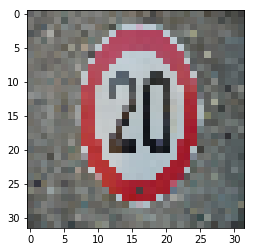

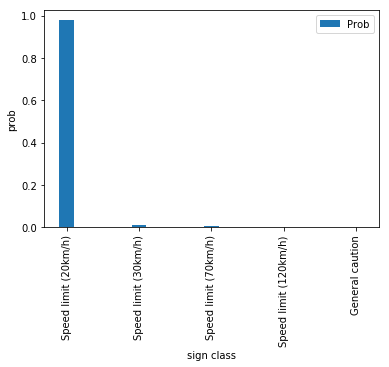

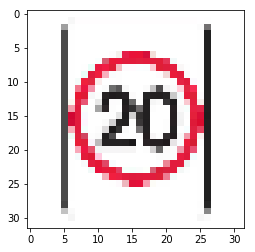

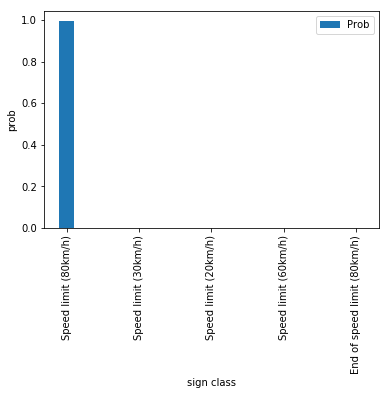

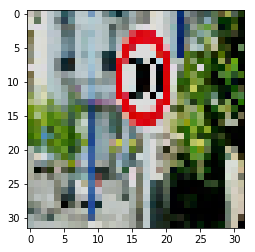

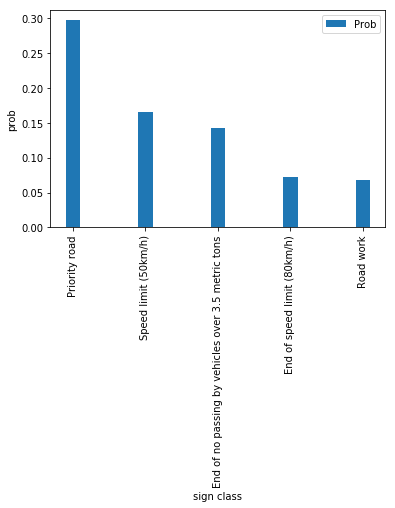

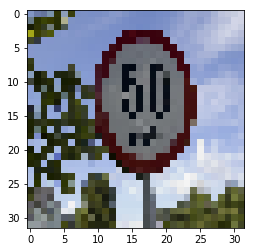

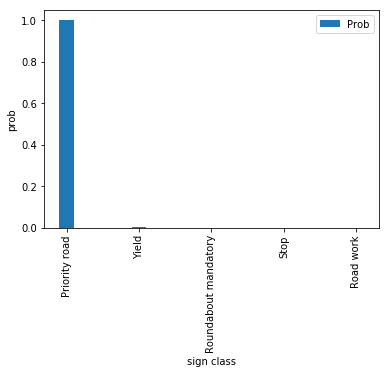

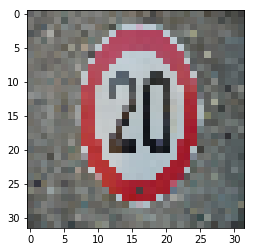

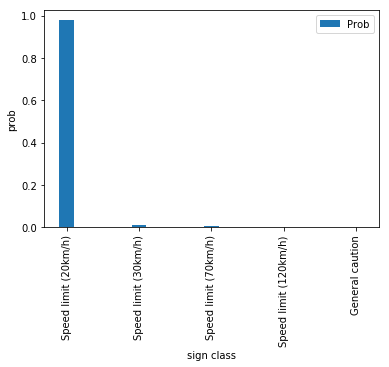

In [89]:
#prob: 0.978146  class: 0 labels: 0
#     prob: 0.0109876  class: 1 labels: 16
#     prob: 0.00767156  class: 4 labels: 16
#     prob: 0.00146429  class: 8 labels: 16
#     prob: 0.000890397  class: 18 labels: 16
gs1 = gridspec.GridSpec(3, 2)
#this spacing doesnt make a difference
gs1.update(wspace=2.0, hspace= 2.0)

plt.subplots(1,1)
plt.imshow(X_OUTSIDE_IMAGE[0],cmap='gray')
fig, ax = plt.subplots(1,1)

plt.bar(np.arange(5), top_k_vals[0], 0.2,label='Prob')
plt.xlabel('sign class')
plt.ylabel('prob')
plt.xticks(index, (csv_dict[label[0][0]],csv_dict[label[0][1]],csv_dict[label[0][2]],csv_dict[label[0][3]],csv_dict[label[0][4]]), rotation='vertical')
plt.legend()

plt.subplots(1,1)
plt.imshow(X_OUTSIDE_IMAGE[1],cmap='gray')


fig, ax = plt.subplots(1,1)
plt.bar(np.arange(5), top_k_vals[1], 0.2,label='Prob')
plt.xlabel('sign class')
plt.ylabel('prob')
plt.xticks(index, (csv_dict[label[1][0]],csv_dict[label[1][1]],csv_dict[label[1][2]],csv_dict[label[1][3]],csv_dict[label[1][4]]), rotation='vertical')
plt.legend()

plt.subplots(1,1)
plt.imshow(X_OUTSIDE_IMAGE[2],cmap='gray')

fig, ax = plt.subplots(1,1)
plt.bar(np.arange(5), top_k_vals[2], 0.2,label='Prob')
plt.xlabel('sign class')
plt.ylabel('prob')
plt.xticks(index, (csv_dict[label[2][0]],csv_dict[label[2][1]],csv_dict[label[2][2]],csv_dict[label[2][3]],csv_dict[label[2][4]]), rotation='vertical')
plt.legend()

plt.subplots(1,1)
plt.imshow(X_OUTSIDE_IMAGE[3],cmap='gray')

fig, ax = plt.subplots(1,1)
plt.bar(np.arange(5), top_k_vals[3], 0.2,label='Prob')
plt.xlabel('sign class')
plt.ylabel('prob')
plt.xticks(index, (csv_dict[label[3][0]],csv_dict[label[3][1]],csv_dict[label[3][2]],csv_dict[label[3][3]],csv_dict[label[3][4]]), rotation='vertical')
plt.legend()

plt.subplots(1,1)
plt.imshow(X_OUTSIDE_IMAGE[4],cmap='gray')

fig, ax = plt.subplots(1,1)
plt.bar(np.arange(5), top_k_vals[4], 0.2,label='Prob')
plt.xlabel('sign class')
plt.ylabel('prob')
plt.xticks(index, (csv_dict[label[4][0]],csv_dict[label[4][1]],csv_dict[label[4][2]],csv_dict[label[4][3]],csv_dict[label[4][4]]), rotation='vertical')
plt.legend()

#plt.tight_layout()
plt.show()

In [2]:
import os
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout,Convolution2D,MaxPooling2D,Flatten
from keras.optimizers import Adam


# number of classes
nb_classes = 43

# input image dimensions
img_rows, img_cols, img_ch = 32, 32, 3

# number of convolutional filters to use
nb_filter1 = 32
nb_filter2 = 64
nb_filter3 = 128



model = Sequential()
model.add(Convolution2D(32, kernel_size=(5, 5),padding='same',
                        input_shape=(img_rows,img_cols,img_ch),name='conv1'))
model.add(Activation('relu',name='relu1'))
model.add(MaxPooling2D(pool_size=(2,2),strides=1,name='maxpool1'))
model.add(Convolution2D(64, kernel_size=(5, 5),padding='same',
                        name='conv2'))
model.add(Activation('relu',name='relu2'))
model.add(MaxPooling2D(pool_size=(2,2),strides=None,name='maxpool2'))
model.add(Convolution2D(128, kernel_size=(5, 5), padding='same',
                        name='conv3'))
model.add(Activation('relu',name='relu3'))
model.add(MaxPooling2D(pool_size=(2,2),strides=None,name='maxpool3'))
model.add(Flatten(name='flatten'))
model.add(Dropout(0.5,name='dropout1'))
model.add(Dense(128, name='hidden1'))
model.add(Activation('relu',name='relu4'))
model.add(Dropout(0.5,name='dropout2'))
model.add(Dense(128,  name='hidden2'))
model.add(Activation('relu',name='relu5'))
model.add(Dense(nb_classes, name='output'))
model.add(Activation('softmax',name='softmax'))

model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 32, 32, 32)        2432      
_________________________________________________________________
relu1 (Activation)           (None, 32, 32, 32)        0         
_________________________________________________________________
maxpool1 (MaxPooling2D)      (None, 31, 31, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 31, 31, 64)        51264     
_________________________________________________________________
relu2 (Activation)           (None, 31, 31, 64)        0         
_________________________________________________________________
maxpool2 (MaxPooling2D)      (None, 15, 15, 64)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 15, 15, 128)       204928    
__________

In [7]:
from sklearn.preprocessing import LabelEncoder
import keras
from keras.utils.np_utils import to_categorical

def normalize_images(X):
    return normalize(X)

X_train = normalize_images(X_train)
X_test = normalize_images(X_test)
X_valid = normalize_images(X_valid)

# one-hot encoding of labels
def one_hot(Y):
    encoder = LabelEncoder()
    encoder.fit(Y)
    encoded_Y = encoder.transform(Y)
    dummy_Y = keras.utils.np_utils.to_categorical(encoded_Y)
    return dummy_Y
#THESE ARE NEVER USED!!! 
y_train_keras = one_hot(y_train)
y_test_keras  = one_hot(y_test)
y_valid_keras = one_hot(y_valid)

In [31]:
nb_epoch = 1000
batch_size=128

model_name='test.chkpt'

if os.path.isfile(model_name):
    try:
        model = load_model(model_name)
        print('loading trained model ...')
    except Exception as e:
        print('Unable to load model', model_name, ':', e)
        raise    


adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=adam,
          loss='categorical_crossentropy',
          metrics=['accuracy'])

startTime = time.time()
history = model.fit(X_train, y_train,
                    batch_size=batch_size, epochs=nb_epoch,
                    verbose=2, validation_data=(X_valid, y_valid))

endTime = time.time()
print('elapsed secs:', (endTime - startTime)/1000.)


Train on 34799 samples, validate on 12630 samples
Epoch 1/1000
8s - loss: 3.4030 - acc: 0.1052 - val_loss: 2.8243 - val_acc: 0.2736
Epoch 2/1000
7s - loss: 2.4650 - acc: 0.3352 - val_loss: 1.7907 - val_acc: 0.4823
Epoch 3/1000
7s - loss: 1.7054 - acc: 0.4946 - val_loss: 1.2250 - val_acc: 0.6491
Epoch 4/1000
7s - loss: 1.2497 - acc: 0.6130 - val_loss: 0.8943 - val_acc: 0.7330
Epoch 5/1000
7s - loss: 0.9625 - acc: 0.6967 - val_loss: 0.6928 - val_acc: 0.8096
Epoch 6/1000
7s - loss: 0.7724 - acc: 0.7524 - val_loss: 0.5770 - val_acc: 0.8444
Epoch 7/1000
7s - loss: 0.6376 - acc: 0.7974 - val_loss: 0.4859 - val_acc: 0.8675
Epoch 8/1000
7s - loss: 0.5355 - acc: 0.8305 - val_loss: 0.4170 - val_acc: 0.8843
Epoch 9/1000
7s - loss: 0.4556 - acc: 0.8563 - val_loss: 0.3728 - val_acc: 0.8960
Epoch 10/1000
7s - loss: 0.4009 - acc: 0.8728 - val_loss: 0.3402 - val_acc: 0.9072
Epoch 11/1000
7s - loss: 0.3504 - acc: 0.8911 - val_loss: 0.3157 - val_acc: 0.9129
Epoch 12/1000
7s - loss: 0.3098 - acc: 0.9026 

In [32]:
model.evaluate(X_test, y_test)

12576/12630 [============================>.] - ETA: 0s 

[0.10388544918002131, 0.98210609659540771]

In [37]:
print(history.history.keys())

dict_keys(['val_acc', 'loss', 'acc', 'val_loss'])


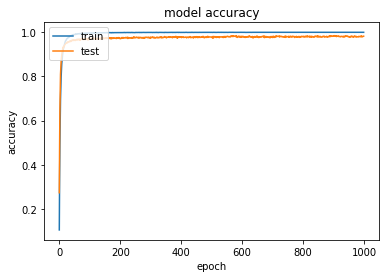

In [38]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

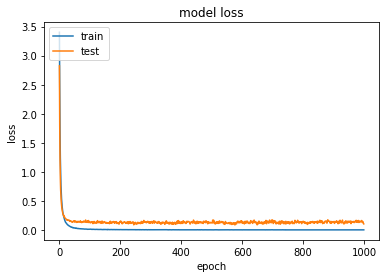

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()